In [15]:
import matplotlib.pyplot as plt
import pandas as pd 
import spotipy 
import librosa
import librosa.display
import numpy as np
import matplotlib as mpl
import urllib.request
import seaborn as sns
import tqdm
import scipy
import joblib
import os.path
from pathlib import Path
from IPython.display import Audio, Markdown, Image
from spotipy.oauth2 import SpotifyClientCredentials

# Números y Datos
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import interp1d

# Análisis de sonido
import librosa
import librosa.display
import spotipy 
from spotipy.oauth2 import SpotifyClientCredentials 

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.preprocessing import quantile_transform

from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
from sklearn import datasets

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import SpectralClustering

from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score


#sns.set_context('poster')
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Levanto toda la data

In [2]:
#df_num = pd.read_pickle('../sources/df_merged_all_quantiles_mediana_iqr.pickle')
df_num = pd.read_pickle('../sources/df_merged_posta_preprocesado.pickle')

genre_real = df_num['genre']

df_num = df_num.drop('genre',1)

Selecciono las variables, que son con las que voy a proceder en el resto del trabajo.

Así que empiezo a remover las variables que considero que no me van a ayudar para una apropiada clasificacion que genere algún sentido de explicación

In [3]:
list(df_num.columns)

['af_duration_ms',
 'af_danceability',
 'af_energy',
 'af_loudness',
 'af_speechiness',
 'af_acousticness',
 'af_liveness',
 'af_valence',
 'af_tempo',
 'aa_confidence_mediana',
 'aa_loudness_start_mediana',
 'aa_loudness_max_time_mediana',
 'aa_loudness_max_mediana',
 'aa_confidence_iqr',
 'aa_loudness_start_iqr',
 'aa_loudness_max_time_iqr',
 'aa_loudness_max_iqr',
 'aa_loudness_start_dif_mediana',
 'aa_loudness_max_time_dif_mediana',
 'aa_loudness_max_dif_mediana',
 'aa_loudness_start_dif_iqr',
 'aa_loudness_max_time_dif_iqr',
 'aa_loudness_max_dif_iqr',
 'aa_pitch_dif_mediana',
 'aa_pitch_dif_iqr',
 'aa_pitch_mediana',
 'aa_pitch_iqr',
 'aa_timbre_dif_mediana',
 'aa_timbre_dif_iqr',
 'aa_timbre_mediana',
 'aa_timbre_iqr']

Miro cómo quedó la distribución de las variables que voy a analizar.
Todas bien normalizadas.

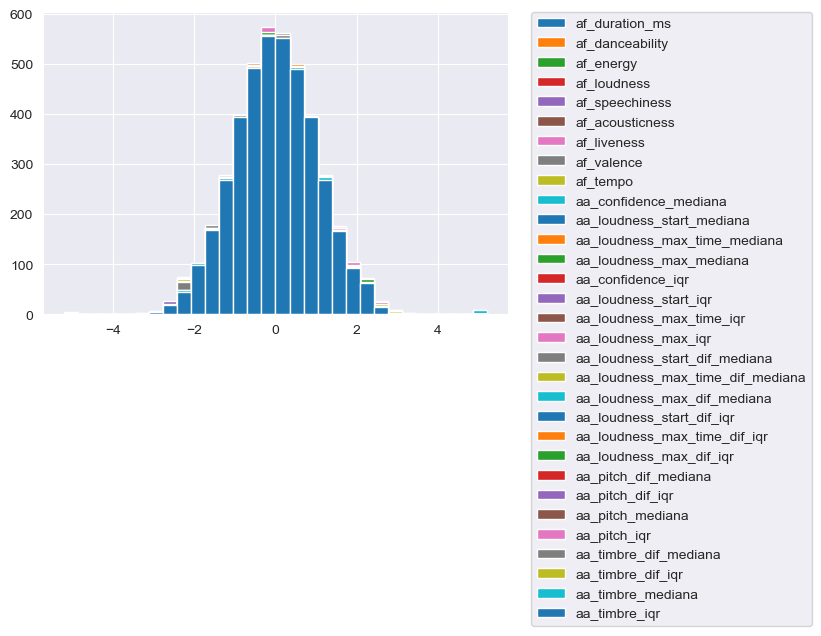

In [4]:
# 
cols = df_num.columns
for k in cols:
    df_num[k].hist(bins=30)
plt.legend(cols,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Y ahora aplico el t-SNE.

In [5]:
tsne = TSNE(n_components=2, perplexity=20, init='pca')
Xred = tsne.fit_transform(df_num)

Y despues grafico para las clases posta

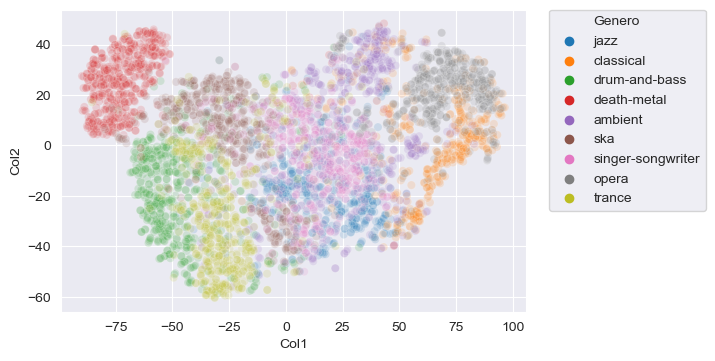

In [6]:
dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Genero":genre_real.values})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Genero",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Vamos a hacer una prueba rápida del dataset y varios tipos de agrupamientos, para ver cómo anda. Después lo analizamos mejor... Esto es nomás para dar un panorama general

In [7]:
len(df_num.columns)
letra = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P']
n=9

Y este es el clustering con k meoides. creo q hay bastante q se asocia bien.

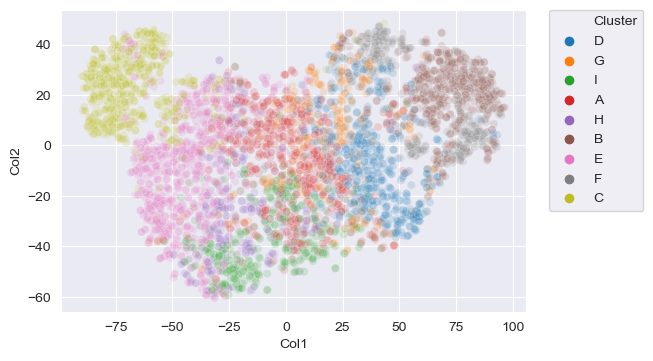

In [8]:
model = KMedoids(metric="euclidean", n_clusters=n, max_iter = 3000, random_state = 0, init='k-medoids++')
model.fit(df_num)
Z = model.predict(df_num)
Z2 = [letra[x] for x in Z]

dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Cluster":Z2})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Cluster",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#    plt._legend.set_title()
plt.show()


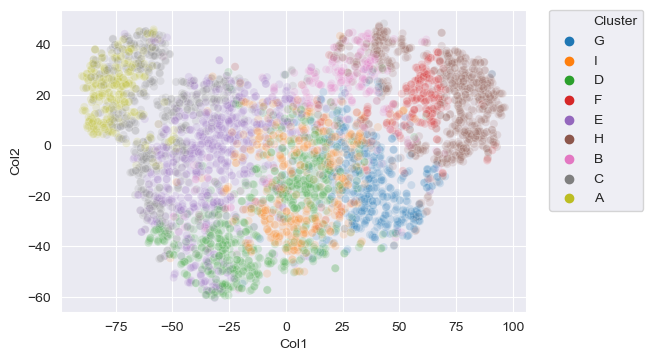

In [16]:
model = KMedoids(metric="euclidean", n_clusters=n, max_iter = 3000, random_state = 1, init='k-medoids++')
model.fit(df_num)
Z = model.predict(df_num)
Z2 = [letra[x] for x in Z]

dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Cluster":Z2})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Cluster",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#    plt._legend.set_title()
plt.show()


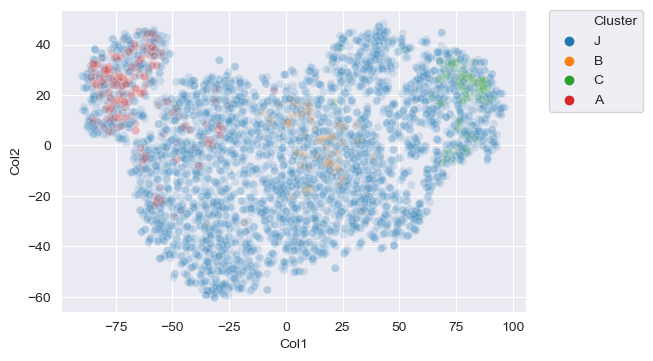

In [17]:
import hdbscan
from sklearn.datasets import make_blobs

clusterer = hdbscan.HDBSCAN(cluster_selection_method='leaf',min_cluster_size=20,alpha=.2,cluster_selection_epsilon=0.1)
Z = clusterer.fit_predict(df_num)
Z2 = [letra[x] for x in Z]


dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Cluster":Z2})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Cluster",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#    plt._legend.set_title()
plt.show()


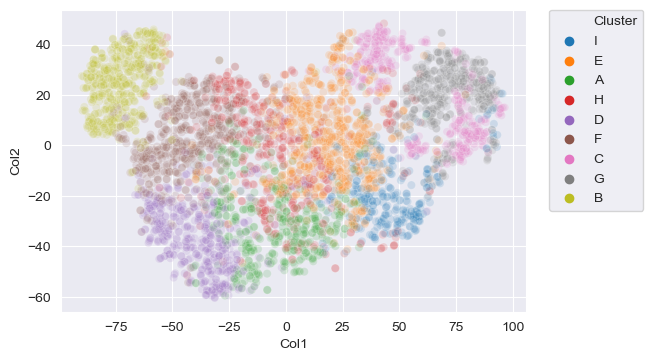

In [18]:
clusterer = SpectralClustering(n_clusters=9,
        assign_labels="kmeans",
        affinity='laplacian',
        gamma=.01,
        n_init=50,
        random_state=0)
Z = clusterer.fit(df_num).labels_
Z2 = [letra[x] for x in Z]

dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Cluster":Z2})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Cluster",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

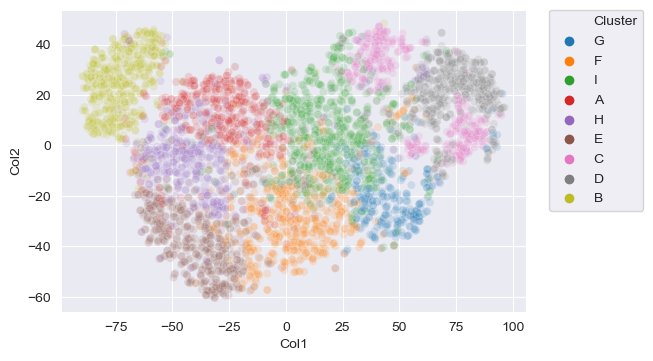

In [19]:
clusterer = SpectralClustering(n_clusters=9,
        assign_labels="discretize",
        affinity='rbf',
        gamma=.05,
        n_init=50,
        random_state=0)
Z = clusterer.fit(df_num).labels_
Z2 = [letra[x] for x in Z]

dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Cluster":Z2})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Cluster",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

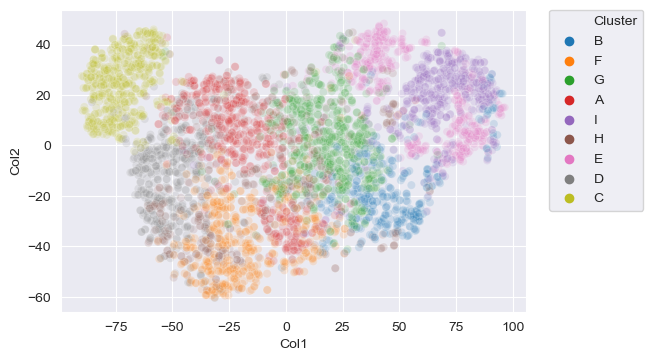

In [20]:
clusterer = SpectralClustering(n_clusters=9,
        assign_labels="discretize",
        affinity='laplacian',
        gamma=.01,
        n_init=50,
        random_state=0)
Z = clusterer.fit(df_num).labels_
Z2 = [letra[x] for x in Z]

dfff = pd.DataFrame ({"Col1":Xred[:,0],"Col2":Xred[:,1],"Cluster":Z2})
sns.scatterplot(data=dfff, x="Col1", y="Col2", hue="Cluster",alpha=0.15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)